In [2]:
import numpy as np
import matplotlib.pyplot as pyplot
from scipy.interpolate import griddata
import matplotlib.colors as colors

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit
import pandas as pd

import DataPreprocessing

## Data Processing

In [3]:
combs = ['1,3','1,4','2,3','2,4']
#combs = ['1,4','1,5','1,6','2,4','2,5','2,6','3,4','3,5','3,6']
#combs = ['1,3','2,3']

In [10]:
##Obtain & process data NPY
#me_train, mom_train = DataPreprocessing.npy('LO/MG_uuxg/3Jet_3000000.npy', 'LO/LO_3_0.01_NJet/PS3_0.01_3000000.npy', ['3,5', '4,5'], 100000, frac=0.1)
#me_test, mom_test = DataPreprocessing.npy('LO/MG_uuxg/3Jet_500000.npy', 'LO/LO_3_0.01_NJet/PS3_0.01_500000.npy', ['3,5', '4,5'], 100000, frac=0.1)

#me_train, mom_train = DataPreprocessing.npy('LO/MG_uuxg_2/me_3jet_1000000.npy', 'LO/MG_uuxg_2/mom_3jet_1000000.npy', ['1,3','2,3'], 100000, frac=1)
#me_test, mom_test = DataPreprocessing.npy('LO/MG_uuxg_2/me_3jet_100000.npy', 'LO/MG_uuxg_2/mom_3jet_100000.npy', ['1,3','2,3'], 100000, frac=1)

me_train, mom_train = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_1000000', 'LO/MG_uuuxux/mom_4jet_1000000', combs, 1000, frac=0.005)
me_test, mom_test = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_100000', 'LO/MG_uuuxux/mom_4jet_100000', combs, 1000, frac=0.005)

#me_train, mom_train = DataPreprocessing.npy('me_6jet_100000.npy', 'mom_6jet_100000.npy', combs, 10000, frac=0.001)
#me_test, mom_test = DataPreprocessing.npy('me_6jet_10000.npy', 'mom_6jet_10000.npy', combs, 10000, frac=0.1)


mom_train = np.append(mom_train, DataPreprocessing.mandel_creation(combs, mom_train).T, axis=1)
mom_test = np.append(mom_test, DataPreprocessing.mandel_creation(combs, mom_test).T, axis=1)

#mom_train = mom_train[:,3:]
#mom_test = mom_test[:,3:]

#mom_train = DataPreprocessing.mandel_creation(combs, mom_train).T
#mom_test = DataPreprocessing.mandel_creation(combs, mom_test).T

#mom_train=np.delete(mom_train, [0,1,2,3,7,11,15], axis=1)
#mom_test=np.delete(mom_test, [0,1,2,3,7,11,15], axis=1)

#mom_train = np.append(mom_train, np.square(mom_train),axis=1)
#mom_test = np.append(mom_test, np.square(mom_test),axis=1)

##Rescale
#scaler = StandardScaler()

#mom_train = scaler.fit_transform(mom_train) #Rescale on training set
#mom_test = scaler.transform(mom_test) #Rescale on test set

## Polynomial Fit:

Small Multiplicity Polynomial Fit

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=4)
poly_train = poly_features.fit_transform(mom_train)
poly_test = poly_features.transform(mom_test)

poly_train = poly_train[:,16:]
poly_test = poly_test[:,16:]

linreg = LinearRegression().fit(poly_train, me_train)

me_predict_lin = linreg.predict(poly_test) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print('RMSE: {}'.format(np.sqrt(lin_mse)))


lin_perc = np.mean(100*np.divide(np.abs(me_test - me_predict_lin), me_test))
print('Percentage Error: {}'.format(lin_perc))

RMSE: 831281290.2837495
Percentage Error: 192.41141236732545


Large Multiplicity Polynomial Fit

Learning Curve

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
        linreg, poly_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.0002, 1, 6), 
        n_jobs=1, verbose=1)

[learning_curve] Training set sizes: [   1 1601 3200 4800 6400 8000]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 11.0min finished


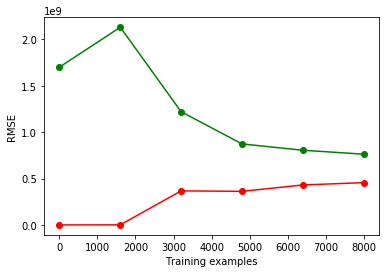

In [9]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.xlabel("Training examples")
pyplot.ylabel("RMSE")
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")


Error Plot

In [ ]:
#s12, s13, s23 = DataPreprocessing.mandel_creation(['3,4','3,5','4,5'], mom_test)
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test)
S = s12 + s13 + s23
print(S)

In [ ]:
x1 = np.divide(s12, S)
x2 = np.divide(s13, S)
x3 = np.divide(s23, S)
print(x3)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [ ]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
grid = griddata((x2, x3), 100*np.divide(np.abs(me_test - me_predict_lin), me_test), (X2i, X3i), method='linear') 

In [ ]:
fig, ax = pyplot.subplots()
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 500])
ax.set_xticklabels([0, 1])
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x2')
ax.set_xlabel('x3')